# Excitation Generation via ForecastPFN

In this example, we demonstrate how to generate incentive signals based on the method of time series combination proposed in [`ForecastPFN`](https://arxiv.org/abs/2311.01933). The paper primarily trained a zero-shot time series prediction model using a prior feature fitting network approach on a large amount of synthetic data.

In the S2Generator, we have improved the data generation method from the original code and provided a Python-based object-oriented programming interface to make parameter management and invocation easier.

The original code link is: https://github.com/abacusai/ForecastPFN.

This method considers the time series $y_t$ to be composed of trends and a large number of cyclical components with different frequencies. These cyclical components include weeks, months, and years. Finally, some random noise is added to the generated sequence data. For the target generated time series $y_t$, we can view it as a combination of trends and cycles:

$$
y_t = \phi(t) \cdot z_t = \mathrm{trend}(t) \cdot \mathrm{seasonal}(t) \cdot z_t,
$$
where, $z_t$ is the noise time series and can be represented as

$$
z_t = 1 + m_{\mathrm{noise}}(z - \bar{z}),
$$
where, $z \sim \mathrm{Weibull}(1, k)$, $\bar{z} = (\mathrm{ln}2) ^ {1 / k}$.

The trend component is made up of a linear and exponential component with coefficients:
$$
\mathrm{trend}(t) = (1 + m_{\mathrm{linear}} \cdot t + c_{\mathrm{linear}})(m_{\mathrm{exp}} \cdot c_{\mathrm{exp} ^ t}),
$$
where, $m_{\mathrm{linear}}, m_{\mathrm{exp}} ~ \mathcal{N}(-0.01, 0.5)$, $c_{\mathrm{linear}} \sim \mathcal{N}(0, 0.01)$, $c_{\mathrm{exp}} \sim \mathcal N (1, 0.0005)$.

For the periodic components, we model them based on the basic idea of Fourier decomposition, representing the periodic components as a combination of different sine and cosine signals, and combining them according to weeks, months, and years. Specifically, it can be expressed as:

$$
\mathrm{seasonal}(t) = \mathrm{seasonal_{week}}(t) \cdot \mathrm{seasonal_{month}}(t) \cdot \mathrm{seasonal_{year}}(t),
$$

where, the seasonal can be represented as
$$
\mathrm{seasonal}_{\nu}(t) = 1 + m_{\nu} \sum_{f = 1}^{\left \lfloor p_{\nu / 2} \right \rfloor }\left [ c_{f, \nu} \mathrm{sin} \left ( 2 \pi f \frac{t}{p_{\nu}} \right ) + d_{f, \nu} \mathrm{cos} \left ( 2 \pi f \frac{t}{p_{\nu}} \right ) \right ].
$$
We set each $m_{\nu} \in \left \{ \mathrm{week}, \mathrm{month}, \mathrm{year} \right \}$, separately for daily, weekly, and monthly, as follows. $\nu = 0$ unless specified:

- Daily: $m_{\mathrm{week}} \sim \mathcal{U}([0, 1])$, $m_{\mathrm{month}} \sim \mathcal{U}([0, 2])$, $p_{\mathrm{week}} = 7$, $p_{\mathrm{week}} = 30.5$.
- Weekly: $m_{\mathrm{week}} \sim \mathcal{U}([0, 3])$, $m_{\mathrm{month}} \sim \mathcal{U}([0, 1])$, $p_{\mathrm{week}} = 2$, $p_{\mathrm{week}} = 52$.
- Monthly: $m_{\mathrm{year}} \sim \sim \mathcal{U}([0, 5])$, $p_{\mathrm{year}} = 12.$



In [2]:
import numpy as np
from matplotlib import pyplot as plt
from S2Generator.excitation import ForecastPFN

# Create the instance for ForecastPFN
forecast_pfn = ForecastPFN(
    start_time="1885-01-01", end_time=None
)  # We use real year, month, and day information as timestamps for data generation

# Create the random number generator
rng = np.random.RandomState(0)

# Generate the excitation through `generate` method
time_series = forecast_pfn.generate(
    rng=np.random.RandomState(0), input_dimension=1, n_inputs_points=256
)

print(
    f"The Excitation Method: {str(forecast_pfn)} and Generate the Time Series Data with Shape: {time_series.shape}"
)

The Excitation Method: ForecastPFN and Generate the Time Series Data with Shape: (256, 1)


We recorded the specific parameters generated during the data generation process and encapsulated them into specific local class attributes. We can further examine the scale, offset, and noise components after invoking the `generate` method.

Amplitude scaling configuration: ComponentScale(base=1.0, linear=0.008295710936443924, exp=0.9989634100141357, a=0.0, m=0.14483352732230867, w=0.45860396176858587, h=0.0, minute=0.0)
Baseline offset configuration: ComponentScale(base=0.0, linear=0.4589993036974507, exp=0.432124841470091, a=0.0, m=0.14483352732230867, w=0.45860396176858587, h=0.0, minute=0.0)
Noise generation configuration: ComponentNoise(k=2.3108816062284756, median=1.0, scale=0.3272122110894283)


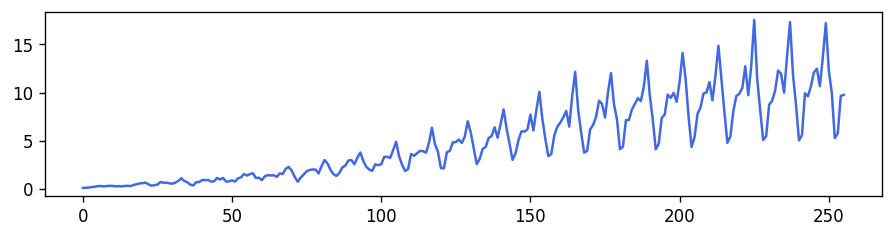

In [3]:
# # Visualization for the excitation
fig, ax = plt.subplots(figsize=(9, 2), dpi=120)

ax.plot(time_series, color="royalblue")

# Check the params for the basis configure
print("Amplitude scaling configuration:", forecast_pfn.scale_config)
print("Baseline offset configuration:", forecast_pfn.offset_config)
print("Noise generation configuration:", forecast_pfn.noise_config)

We also provide an interface that can directly observe all parameter components within it.

In [4]:
# Get the time series configuration
time_series_config = forecast_pfn.time_series_config

print("Comprehensive configuration for time series generation:")
print(
    "Compact string representation encoding key parameters:",
    forecast_pfn.time_series_config,
)
print("scale:", time_series_config.scale)
print("offset:", time_series_config.offset)
print("noise:", time_series_config.noise_config)

Comprehensive configuration for time series generation:
Compact string representation encoding key parameters: L+8E-10A00M14W46
scale: ComponentScale(base=1.0, linear=0.008295710936443924, exp=0.9989634100141357, a=0.0, m=0.14483352732230867, w=0.45860396176858587, h=0.0, minute=0.0)
offset: ComponentScale(base=0.0, linear=0.4589993036974507, exp=0.432124841470091, a=0.0, m=0.14483352732230867, w=0.45860396176858587, h=0.0, minute=0.0)
noise: ComponentNoise(k=2.3108816062284756, median=1.0, scale=0.3272122110894283)


Further breakdown allows us to observe the specific magnitudes of each frequency component.

In [5]:
print("Annual seasonality component weight(s):", forecast_pfn.annual)
print("Weekly seasonality component weight(s)", forecast_pfn.weekly)
print("Hourly seasonality component weight(s)", forecast_pfn.hourly)
print("Minute-level seasonality component weight(s)", forecast_pfn.minutely)

Annual seasonality component weight(s): 0.0
Weekly seasonality component weight(s) 0.45860396176858587
Hourly seasonality component weight(s) 0.0
Minute-level seasonality component weight(s) 0.0


We can also generate multi-channel time series data by specifying the number of generated channel dimensions using the `generate` method.

The Excitation Method: ForecastPFN and Generate the Time Series Data with Shape: (512, 4)


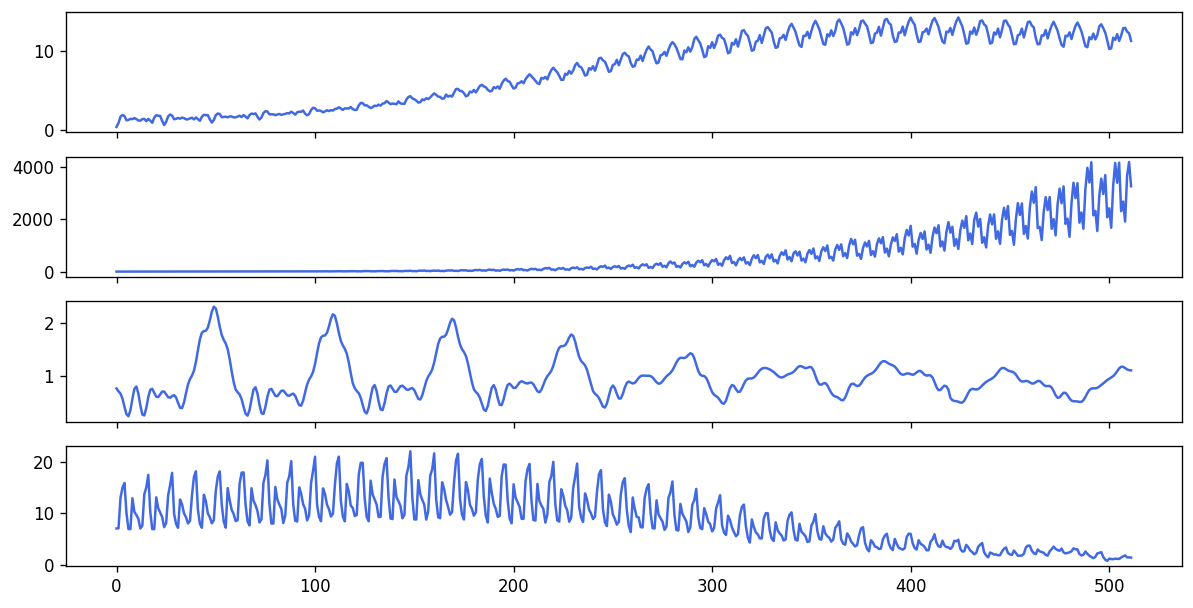

In [10]:
# Generate the multi-dimension time series data
time_series = forecast_pfn.generate(
    rng=np.random.RandomState(666), input_dimension=4, n_inputs_points=512
)
print(
    f"The Excitation Method: {str(forecast_pfn)} and Generate the Time Series Data with Shape: {time_series.shape}"
)

# Visualize the multi-dimension time series data
fig, ax = plt.subplots(4, 1, figsize=(12, 6), dpi=120, sharex=True)
for i in range(4):
    ax[i].plot(time_series[:, i], color="royalblue")